In [4]:
## 0. Imports and Basic Setup
import os
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import joblib

In [21]:
## 1. Load Preprocessed Train, Validation, and Test Splits

train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

In [20]:
## 2. Create Sequences for XGBoost

def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    Create sequences for time series prediction, grouped by location.
    Unlike RNNs which keep the temporal dimension, we flatten the sequences
    for XGBoost into a single feature vector.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with time series data
    feature_cols (list): List of feature column names
    target_col (str): Name of the target column
    seq_length (int): Length of sequence to use for prediction
    
    Returns:
    tuple: (X array of shape (n_samples, seq_length * n_features),
            y array of shape (n_samples,),
            metadata DataFrame with columns ["location", "YYYY", "DOY", "MM", "DD"])
    """
    X_list, y_list, metadata_list = [], [], []
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values
        
        for i in range(len(loc_df) - seq_length):
            # Flatten the sequence into a single feature vector
            sequence = loc_features[i:i + seq_length].flatten()
            X_list.append(sequence)
            y_list.append(loc_target[i + seq_length])
            
            metadata = loc_df.iloc[i + seq_length][["location", "YYYY", "DOY", "MM", "DD"]].to_dict()
            metadata_list.append(metadata)
    
    X = np.array(X_list)
    y = np.array(y_list)
    metadata_df = pd.DataFrame(metadata_list)
    
    return X, y, metadata_df

In [22]:
## 3. Define Features and Target

exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


In [23]:
## 4. Generate sequences
SEQ_LENGTH = 30
X_train, y_train, _ = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val, _ = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test, metadata_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)


Train sequence shape: (1202300, 630) (1202300,)
Validation sequence shape: (106600, 630) (106600,)
Test sequence shape: (106500, 630) (106500,)


In [6]:
##  5. Rigorous Hyperparameter Tuning
# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.3, 0.5],
    'subsample': [0.6, 0.8, 0.95],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5]
}

# Create feature names for interpretation
feature_names = [f"{col}_t{i}" for i in range(SEQ_LENGTH) for col in feature_cols]

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# Placeholder for best parameters and performance
best_params = None
best_rmse = float("inf")

# Iterate over all parameter combinations
for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=300,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # Evaluate performance
    val_preds = model.predict(dval)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"Validation RMSE: {val_rmse:.4f}")
    
    # Update best parameters if current RMSE is better
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_params = params

print(f"Best parameters: {best_params}")
print(f"Best validation RMSE: {best_rmse:.4f}")

Testing parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6}
[0]	train-rmse:0.99604	val-rmse:1.01848
[100]	train-rmse:0.88146	val-rmse:0.91375
[200]	train-rmse:0.86778	val-rmse:0.91006
[299]	train-rmse:0.85908	val-rmse:0.90929
Validation RMSE: 0.9093
Testing parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8}
[0]	train-rmse:0.99601	val-rmse:1.01845
[100]	train-rmse:0.88149	val-rmse:0.91367
[200]	train-rmse:0.86748	val-rmse:0.91034
[299]	train-rmse:0.85884	val-rmse:0.90910
Validation RMSE: 0.9091
Testing parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.95}
[0]	train-rmse:0.99600	val-rmse:1.01844
[100]	train-rmse:0.88109	val-rmse:0.91377
[200]	train-rmse:0.86722	val-rmse:0.91047
[299]	train-rmse:0.85859	val-rmse:0.90920
Validation RMSE: 0.9092
Testing parameters: {'colsample_bytree': 0.6, 'lear

In [9]:
feature_names = [f"{col}_t{i}" for i in range(SEQ_LENGTH) for col in feature_cols]

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

In [10]:
## 6. Train Final Model with Best Parameters
# Train model with best parameters
best_params = {
    'colsample_bytree': 0.6, 
    'learning_rate': 0.05, 
    'max_depth': 8, 
    'min_child_weight': 1, 
    'subsample': 0.95
    }


final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:0.99273	val-rmse:1.01276
[100]	train-rmse:0.79984	val-rmse:0.90818
[200]	train-rmse:0.75164	val-rmse:0.90729
[300]	train-rmse:0.71516	val-rmse:0.90690
[400]	train-rmse:0.68425	val-rmse:0.90590
[497]	train-rmse:0.66001	val-rmse:0.90589


In [11]:
## 7. Evaluate the Final Model
# Convert test data to DMatrix format

# Make predictions
test_preds = final_model.predict(dtest)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"\nTest MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")


Test MSE:  0.7971
Test RMSE: 0.8928
Test MAE:  0.5671


In [24]:
## 8. Visualize Predictions
prec_scaler = joblib.load("prec_scaler.pkl")
y_test_rescaled = prec_scaler.inverse_transform(y_test.reshape(-1, 1))
test_preds_rescaled = prec_scaler.inverse_transform(test_preds.reshape(-1, 1))

metadata_test["prec_true"] = y_test_rescaled
metadata_test["prec_pred"] = test_preds_rescaled

random_loc = metadata_test["location"].sample(1).values[0]
first_year = metadata_test["YYYY"].min() + 1
first_month = 1
last_month = 6

plot_data = metadata_test[(metadata_test["location"] == random_loc) & (metadata_test["YYYY"] == first_year) 
                           & (metadata_test["MM"] >= first_month) & (metadata_test["MM"] <= last_month)]

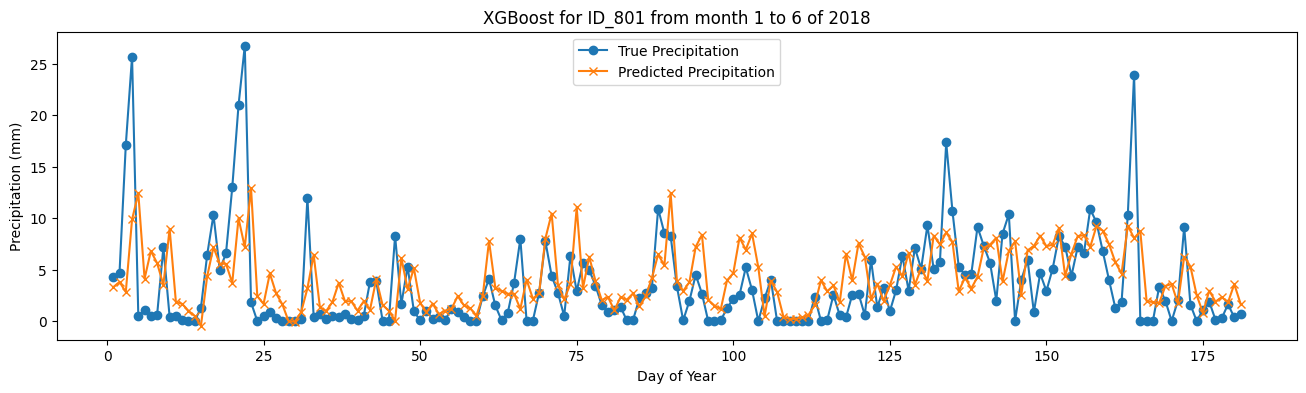

In [49]:
plt.figure(figsize=(16, 4))
plt.plot(plot_data['DOY'], plot_data['prec_true'], label='True Precipitation', marker='o')
plt.plot(plot_data['DOY'], plot_data['prec_pred'], label='Predicted Precipitation', marker='x')
plt.title(f"XGBoost for {random_loc} from month {first_month} to {last_month} of {first_year}")
plt.xlabel("Day of Year")
plt.ylabel("Precipitation (mm)")
plt.legend()
plt.show()

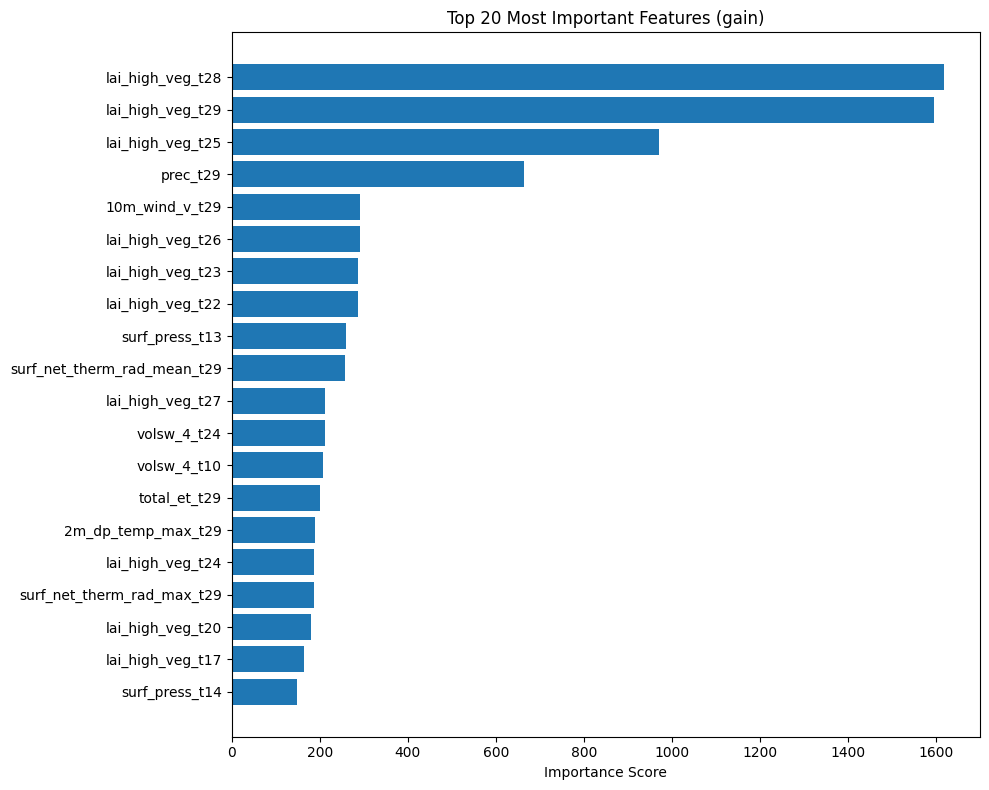

In [11]:
## 9. Feature Importance Study

# Get feature importance scores
importance_scores = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_scores.items()],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].tail(20), importance_df['Importance'].tail(20))
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

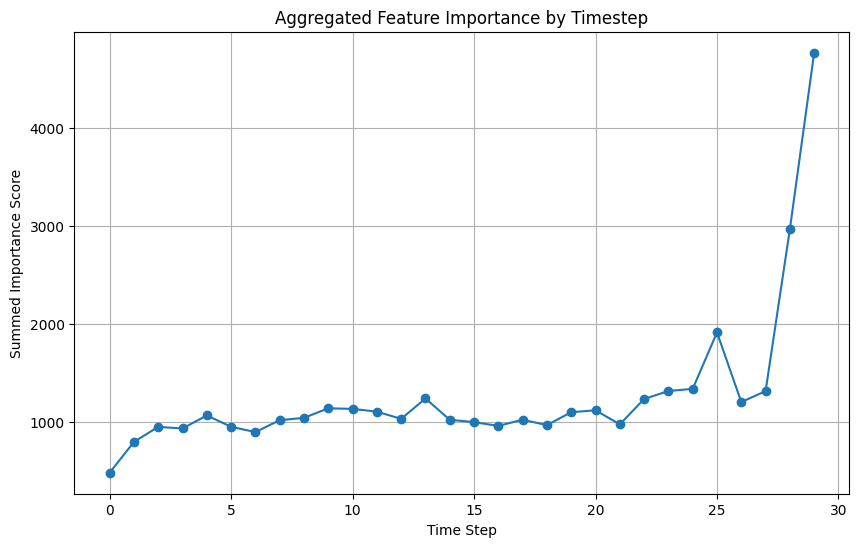

In [12]:
## 10. Analyze Temporal Importance

# Extract timesteps from feature names and aggregate importance by time
def extract_timestep(feature_name):
    return int(feature_name.split('_t')[-1])

importance_df['timestep'] = importance_df['Feature'].apply(extract_timestep)
temporal_importance = importance_df.groupby('timestep')['Importance'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(temporal_importance['timestep'], temporal_importance['Importance'], marker='o')
plt.title('Aggregated Feature Importance by Timestep')
plt.xlabel('Time Step')
plt.ylabel('Summed Importance Score')
plt.grid(True)
plt.show()
